In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!pip install pyglet==1.5.1
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [4]:
%%capture
!pip install gym==0.24
!pip install pygame
!pip install numpy
!pip install imageio imageio_ffmpeg

In [6]:
import numpy as np
import gym
import random
import imageio
from tqdm.notebook import trange

In [39]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False)
env1 = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)

print("Observation Space:", env.observation_space)
print("Sample observation", env.observation_space.sample())

Observation Space: Discrete(16)
Sample observation 4


#### The action space:
##### 0: Move Left
##### 1: Move Down
##### 2: Move Rigt
##### 3: Move Up

#### Reward function
##### Reaching the goal: +1
##### Falling into the hole: 0
##### Staying on the frozen lake: 0

In [8]:
print("Action space shape: ", env.action_space.n)
print("Action space sample: ", env.action_space.sample())

Action space shape:  4
Action space sample:  3


In [41]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

state_space1 = env1.observation_space.n
print("There are ", state_space1, " possible states")

action_space1 = env1.action_space.n
print("There are ", action_space1, " possible actions")

There are  16  possible states
There are  4  possible actions
There are  64  possible states
There are  4  possible actions


In [58]:
def initialize_Q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

Qtable_frozenlake = initialize_Q_table(state_space, action_space)
Qtable_frozenlake1 = initialize_Q_table(state_space1, action_space1)

In [49]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  random_int = random.uniform(0,1)
  if random_int > epsilon:
    action = np.argmax(Qtable[state])
  else:
    action = env.action_space.sample()
  return action

In [50]:
def epsilon_greedy_policy1(Qtable, state, epsilon):
  random_int = random.uniform(0,1)
  if random_int > epsilon:
    action = np.argmax(Qtable[state])
  else:
    action = env1.action_space.sample()
  return action

In [13]:
def greedy_policy(Qtable, state):
  action = np.argmax(Qtable[state])

  return action

In [62]:
# Training parameters
n_training_episodes = 100000
learning_rate = 0.5

# Evaluation parameters
n_eval_episodes = 100

# Environment parameters
env_id = "FrozenLake-v1"
max_steps = 99
gamma = 0.95
eval_seed = []

# Exploration parameters
max_epsilon = 1.0
min_epsilon = 0.005
decay_rate = 0.00005

In [15]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in trange(n_training_episodes):
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)

    # Reset the environment
    state = env.reset()
    step = 0
    done = False

    # Repeat
    for step in range(max_steps):
      action = epsilon_greedy_policy(Qtable, state, epsilon)
      new_state, reward, done, info = env.step(action)
      Qtable[state][action] = Qtable[state][action] + learning_rate*(reward + gamma*np.max(Qtable[new_state]) - Qtable[state][action])

      # if done, finish the episode
      if done:
        break
      state = new_state

  return Qtable

In [17]:
Qtable_frozenlake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
Qtable_frozenlake

array([[0.73509189, 0.77378094, 0.77378094, 0.73509189],
       [0.73509189, 0.        , 0.81450625, 0.77378094],
       [0.77378094, 0.857375  , 0.77378094, 0.81450625],
       [0.81450625, 0.        , 0.77378094, 0.77378094],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.        , 0.81450625],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.        , 0.857375  , 0.77378094],
       [0.81450625, 0.9025    , 0.9025    , 0.        ],
       [0.857375  , 0.95      , 0.        , 0.857375  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.95      , 0.857375  ],
       [0.9025    , 0.95      , 1.        , 0.9025    ],
       [0.        , 0.        , 0.        , 0.        ]])

In [19]:
from types import new_class
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
  episode_rewards = []
  for episode in range(n_eval_episodes):
    if seed:
      state = env.reset(seed=seed[episode])
    else:
      state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0

    for step in range(max_steps):
      action = np.argmax(Q[state][:])
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward

      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [21]:
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward} +/- {std_reward: .2f}")

Mean_reward=1.0 +/-  0.00


In [25]:
def record_video(env, Qtable, out_directory, fps=1):
  images = []
  done = False
  state = env.reset(seed=random.randint(0,500))
  img = env.render(mode='rgb_array')
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(Qtable[state][:])
    state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

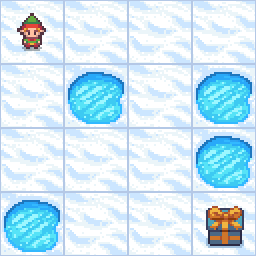

In [30]:
video_path="/content/drive/MyDrive/Reinforcement Learning/replay.gif"
video_fps=1
record_video(env, Qtable_frozenlake, video_path, video_fps)

from IPython.display import Image
Image(video_path)

In [63]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env1, max_steps, Qtable):
  for episode in trange(n_training_episodes):
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)

    # Reset the environment
    state = env1.reset()
    step = 0
    done = False

    # Repeat
    for step in range(max_steps):
      action = epsilon_greedy_policy1(Qtable, state, epsilon)
      new_state, reward, done, info = env1.step(action)
      Qtable[state][action] = Qtable[state][action] + learning_rate*(reward + gamma*np.max(Qtable[new_state]) - Qtable[state][action])

      # if done, finish the episode
      if done:
        break
      state = new_state

  return Qtable

In [64]:
Qtable_frozenlake1 = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env1, max_steps, Qtable_frozenlake1)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [65]:
Qtable_frozenlake1

array([[0.48767498, 0.51334208, 0.51334208, 0.48767498],
       [0.48767498, 0.54036009, 0.54036009, 0.51334208],
       [0.51334208, 0.56880009, 0.56880009, 0.54036009],
       [0.54036009, 0.59873694, 0.59873694, 0.56880009],
       [0.56880009, 0.63024941, 0.63024941, 0.59873694],
       [0.59873694, 0.66342043, 0.66342043, 0.63024941],
       [0.63024941, 0.6983373 , 0.6983373 , 0.66342043],
       [0.66342043, 0.73509189, 0.6983373 , 0.6983373 ],
       [0.51334208, 0.54036009, 0.54036009, 0.48767498],
       [0.51334208, 0.56880009, 0.56880009, 0.51334208],
       [0.54036009, 0.59873694, 0.59873694, 0.54036009],
       [0.56880009, 0.        , 0.63024941, 0.56880009],
       [0.59873694, 0.66342043, 0.66342043, 0.59873694],
       [0.63024941, 0.6983373 , 0.6983373 , 0.63024941],
       [0.66342043, 0.73509189, 0.73509189, 0.66342043],
       [0.6983373 , 0.77378094, 0.73509189, 0.6983373 ],
       [0.54036009, 0.56880009, 0.56880009, 0.51334208],
       [0.54036009, 0.59873694,

In [66]:
def evaluate_agent(env1, max_steps, n_eval_episodes, Q, seed):
  episode_rewards = []
  for episode in range(n_eval_episodes):
    if seed:
      state = env1.reset(seed=seed[episode])
    else:
      state = env1.reset()
    step = 0
    done = False
    total_rewards_ep = 0

    for step in range(max_steps):
      action = np.argmax(Q[state][:])
      new_state, reward, done, info = env1.step(action)
      total_rewards_ep += reward

      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward1 = np.mean(episode_rewards)
  std_reward1 = np.std(episode_rewards)

  return mean_reward1, std_reward1

In [67]:
mean_reward1, std_reward1 = evaluate_agent(env1, max_steps, n_eval_episodes, Qtable_frozenlake1, eval_seed)
print(f"Mean_reward={mean_reward1} +/- {std_reward1: .2f}")

Mean_reward=1.0 +/-  0.00


In [68]:
def record_video(env1, Qtable, out_directory, fps=1):
  images = []
  done = False
  state = env1.reset(seed=random.randint(0,500))
  img = env1.render(mode='rgb_array')
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(Qtable[state][:])
    state, reward, done, info = env1.step(action) # We directly put next_state = state for recording logic
    img = env1.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

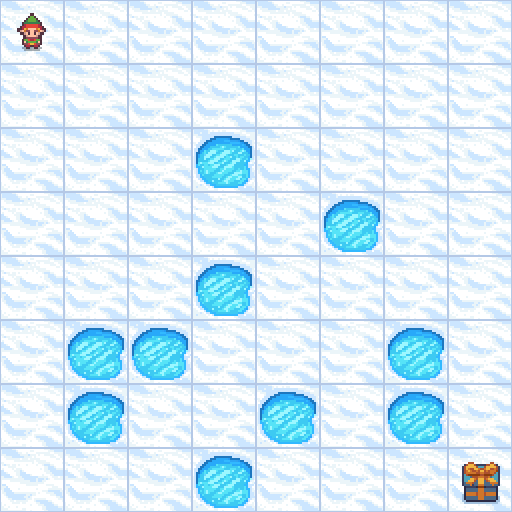

In [71]:
video_path="/content/drive/MyDrive/Reinforcement Learning/replay_map2.gif"
video_fps=1
record_video(env1, Qtable_frozenlake1, video_path, video_fps)

from IPython.display import Image
Image(video_path)